In [42]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras import Input, backend
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, RandomTranslation, RandomFlip
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.backend import clear_session
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

In [43]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [44]:
# Define the custom class names
custom_class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a Dataset object from the training data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Set the class names attribute of the Dataset object
train_dataset.class_names = custom_class_names

In [45]:
### PLOTTING 10 SAMPLES FROM EACH CLASS ###
""" # Create a 10x10 subplot grid
fig, axs = plt.subplots(10, 10, figsize=(6, 6))

# Iterate over each class
for i, c in enumerate(np.unique(y_train)):
    # Select 10 random samples from this class
    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)
    
    # Iterate over the 10 random samples
    for j, idx_j in enumerate(idx):
        # Get the corresponding image
        img = x_train[idx_j]
        
        # Display the image in the subplot
        axs[j, i].imshow(img)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

# Layout so plots do not overlap
fig.tight_layout()
plt.show() """

' # Create a 10x10 subplot grid\nfig, axs = plt.subplots(10, 10, figsize=(6, 6))\n\n# Iterate over each class\nfor i, c in enumerate(np.unique(y_train)):\n    # Select 10 random samples from this class\n    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)\n    \n    # Iterate over the 10 random samples\n    for j, idx_j in enumerate(idx):\n        # Get the corresponding image\n        img = x_train[idx_j]\n        \n        # Display the image in the subplot\n        axs[j, i].imshow(img)\n        axs[j, i].set_xticks([])\n        axs[j, i].set_yticks([])\n\n# Layout so plots do not overlap\nfig.tight_layout()\nplt.show() '

In [46]:
# Convert the labels from numerical to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Normalizing the images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [47]:
### BUILDING THE MODEL ###
clear_session()

# Defining the model
model = Sequential([
    Input(shape=(32, 32, 3)),

    # Data augmentation layers
    RandomTranslation(height_factor=0.05, width_factor=0.05),
    RandomFlip("horizontal"),

    # 1st Convolutional Block
    Conv2D(64, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    Conv2D(64, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # 2nd Convolutional Block
    Conv2D(128, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    Conv2D(128, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 3rd Convolutional Block
    Conv2D(256, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    Conv2D(128, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Dense Layers
    Flatten(),
    Dense(128, kernel_regularizer=l2(0.005)), BatchNormalization(), Activation("relu"),
    Dropout(0.3),

    # Output Layer
    Dense(10, activation='softmax')
])

model.summary()

' model_seq = Sequential()\nmodel_seq.add(Input(shape=(32, 32, 3)))\n\n# Data augmentation layers\nmodel_seq.add(RandomTranslation(height_factor=0.05, width_factor=0.05))\nmodel_seq.add(RandomFlip("horizontal"))\n\n# 1st Convolutional Block\nmodel_seq.add(Conv2D(64, (3, 3), padding=\'same\'))\nmodel_seq.add(BatchNormalization())\nmodel_seq.add(Activation("relu"))\nmodel_seq.add(Conv2D(64, (3, 3), padding=\'same\'))\nmodel_seq.add(BatchNormalization())\nmodel_seq.add(Activation("relu"))\nmodel_seq.add(MaxPooling2D((2, 2)))\nmodel_seq.add(Dropout(0.1))\n\n# 2nd Convolutional Block\nmodel_seq.add(Conv2D(128, (3, 3), padding=\'same\'))\nmodel_seq.add(BatchNormalization())\nmodel_seq.add(Activation("relu"))\nmodel_seq.add(Conv2D(128, (3, 3), padding=\'same\'))\nmodel_seq.add(BatchNormalization())\nmodel_seq.add(Activation("relu"))\nmodel_seq.add(MaxPooling2D((2, 2)))\nmodel_seq.add(Dropout(0.2))\n\n# 3rd Convolutional Block\nmodel_seq.add(Conv2D(256, (3, 3), padding=\'same\'))\nmodel_seq.ad

In [48]:
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss function for multi-class classification.
    
    Args:
        gamma (float): Focusing parameter. Higher values put more focus on hard-to-classify samples.
        alpha (float): Balancing factor to reduce the impact of easy negatives and amplify the importance of hard positives.
    
    Returns:
        Loss function to be used with model.compile.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0) error
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Compute the cross-entropy loss
        ce_loss = -y_true * tf.keras.backend.log(y_pred)
        
        # Calculate the focal loss component
        loss = alpha * tf.keras.backend.pow(1 - y_pred, gamma) * ce_loss
        
        # Return the mean loss across all samples
        return tf.keras.backend.sum(loss, axis=1)
    
    return focal_loss_fixed

In [49]:
### TRAINING THE MODEL ###

# Compiling the model # TODO: Try different accuracy metrics?
model.compile(
    optimizer=Adam(),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    #loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
    )

# Calculate class weights to adjust the loss function based on the training data
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train.argmax(axis=1)),
                                     y=y_train.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict[3] *= 2; class_weights_dict[5] *= 2 

# Define Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Learning Rate Scheduler to adjust the learning rate during training
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)

# Training the model
history = model.fit(x_train, y_train,
    epochs=100, #50
    batch_size=128, #512
    validation_split=0.2,
    class_weight=class_weights_dict,
    #validation_steps=int(0.2 * x_test.shape[0] / 512), # Fixed because we're generating val data automatically with validation_split
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


2024-09-27 07:42:31.323974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


KeyboardInterrupt: 

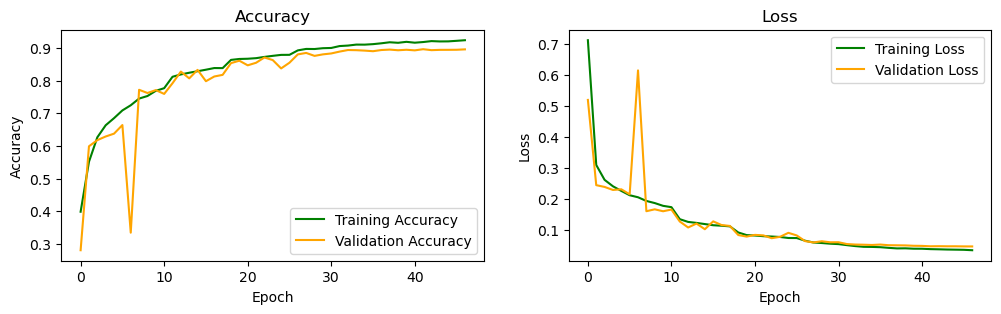

ValueError: You must call `compile()` before using the model.

In [28]:
# Plot Accuracy
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], color='green', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test)

# Get final training metrics
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]

# Get final validation metrics
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f'Training Accuracy:\t{train_acc:.4f},\tLoss: {train_loss:.4f}')
print(f'Validation Accuracy:\t{val_acc:.4f},\tLoss: {val_loss:.4f}')
print(f'Test Accuracy:\t\t{test_acc:.4f},\tLoss: {test_loss:.4f}')

# Adam, DropOuts: Acc = 0.8317 Loss = 0.5056
# Adam, NoDropOuts: Acc = 0.7353 Loss = 0.7353
# SGD, NoDropOuts: Acc = 0.5973 Loss = 1.1429

313/313 [==============================] - 2s 6ms/step


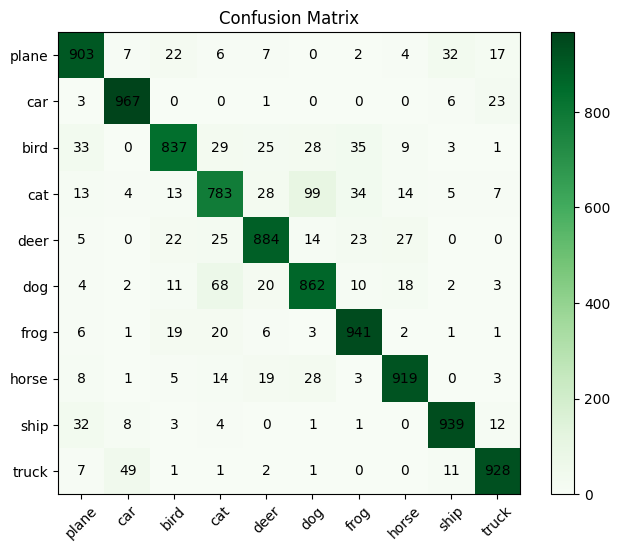

              precision    recall  f1-score   support

       plane       0.89      0.90      0.90      1000
         car       0.93      0.97      0.95      1000
        bird       0.90      0.84      0.87      1000
         cat       0.82      0.78      0.80      1000
        deer       0.89      0.88      0.89      1000
         dog       0.83      0.86      0.85      1000
        frog       0.90      0.94      0.92      1000
       horse       0.93      0.92      0.92      1000
        ship       0.94      0.94      0.94      1000
       truck       0.93      0.93      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [33]:
# Making predictions
y_pred = model.predict(x_test)

# Creating a Confussion matrix
cm = confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Greens')
plt.title('Confusion Matrix')
plt.colorbar()

# Use the custom class names as tick labels
plt.xticks(range(len(custom_class_names)), custom_class_names, rotation=45)
plt.yticks(range(len(custom_class_names)), custom_class_names)

# Add numbers to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()

# Ensure both y_test and y_pred_class are in the same format
y_test_class = np.argmax(y_test, axis=1)

# Display a classification report
print(classification_report(y_test_class, np.argmax(y_pred, axis=1), target_names = custom_class_names))